In [28]:
import gym
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
env = gym.make("CartPole-v0")
env.reset()

print('Env. observation space - High:', env.observation_space.high)
print('Env. observation space - Low:', env.observation_space.low)
print('Env. Actions space :', env.action_space.n)

In [ ]:
#random policy

env = gym.make("CartPole-v0")
for i_episode in range(50):
    observation =env.reset()
    print(observation) #[Horizontal position, Horizonatl velocity, Angle of Pole, Angular velocity]
    for t in range(100):
        env.render() #show popup window with simulation
        action= env.action_space.sample() #take a random action 0:left; 1:Right
        observation, reward, done, info = env.step(action)
        print("action:",action, "Observation:",observation, "reward:", reward, "Done:",done, "Info:",info) 
        if done:
            print(f"Episode finished after {t+1} time steps")
            break
env.close()

In [ ]:
#hard-coded policy

env = gym.make("CartPole-v0")
observation =env.reset()
print(observation) #[Horizontal position, Horizonatl velocity, Angle of Pole, Angular velocity]
for t in range(1000):
    env.render() #show popup window with simulation
    #defining a hard-coded policy
    cart_pos, cart_val, pol_ang, ang_vel = observation
    #Move Cart Right if Pole in Faling to Right
    #Angle is measured off straight vertical line
    if pol_ang >0:
        action = 1 #move right
    else:
        action = 0 #move Left
    #performe action
    observation, reward, done, info = env.step(action)
    print("action:",action, "Observation:",observation, "reward:", reward, "Done:",done, "Info:",info) 
    if done:
        print(f"Episode finished after {t+1} time steps")
        break
env.close()

In [23]:
#When we execute step() it returns a continuous state. Discretised_state(state) function converts these 
#continuous states into discrete states. 
#For training the RL model, the Pole Angle and Angulary Velocity features will be used

def discretised_state(state, theta_minmax, theta_dot_minmax, theta_state_size, theta_dot_state_size):
    #state[2] -> theta
    #state[3] -> theta_dot
    discrete_state = np.array([0,0])        #Initialised discrete array (i.e. Angle of the pole and Angular velocity state
    #Continuous State of Angle of Pole
    theta_window =  ( theta_minmax - (-theta_minmax) ) / theta_state_size
    discrete_state[0] = ( state[2] - (-theta_minmax) ) // theta_window
    discrete_state[0] = min(theta_state_size-1, max(0,discrete_state[0]))
    #Continuous State of Angular velocity
    theta_dot_window =  ( theta_dot_minmax - (-theta_dot_minmax) )/ theta_dot_state_size
    discrete_state[1] = ( state[3] - (-theta_dot_minmax) ) // theta_dot_window
    discrete_state[1] = min(theta_dot_state_size-1, max(0,discrete_state[1]))

    return tuple(discrete_state.astype(np.int32)) #to return Discrete State for Angle of Pole and Angular velocity

In [24]:
def train_cart_pole_qlearning(env, EPISODES, DISCOUNT, EPISODE_DISPLAY, LEARNING_RATE, EPSILON):
    #Q-Table of size theta_state_size * theta_dot_state_size * env.action_space.n
    theta_minmax = env.observation_space.high[2] #Use min and max observation to convert continuous states
    theta_dot_minmax = math.radians(50)          #into discrete states for features Pole Angle and Angular Velocity
    theta_state_size=50                    #50 pole Angle States
    theta_dot_state_size=50                #50 Angular velocity States
    #Q-table initiated with random values - used to calculate the maximum expected future rewards for action at each state. 
    #Q-table dimension varies depending on:
    #      - Environment possible actions (2) - left & right
    #      - Environment number of states (50 pole angle states, 50 angular velocity states) – increased number of states provides a higher resolution of the state space
    Q_TABLE = np.random.randn(theta_state_size,theta_dot_state_size,env.action_space.n)
    print(Q_TABLE.shape)
    print(Q_TABLE[0,0])
    print(Q_TABLE[0,0,1])
    # For stats
    ep_rewards = []
    ep_rewards_table = {'ep': [], 'avg': [], 'min': [], 'max': []} #Dict model stats to verify model learning progression

    for episode in range(EPISODES):
        #Initialize variables at start of episode, including acquisition of first observation after environment reset
        episode_reward = 0
        curr_discrete_state = discretised_state(env.reset(), theta_minmax, theta_dot_minmax, theta_state_size, theta_dot_state_size)
        done = False
        i = 0
        if episode % EPISODE_DISPLAY == 0:
            render_state = True
        else:
            render_state = False
        #Based on Exploration constant, select random action or action with highest Q-value
        while not done:
            if np.random.random() > EPSILON:
                action = np.argmax(Q_TABLE[curr_discrete_state]) #returns index of max value of two possible actions (index=0 or index=1)
            else:
                action = np.random.randint(0, env.action_space.n)
            #Bot executes selected action and acquires observation from new state
            new_state, reward, done, _ = env.step(action)
            new_discrete_state = discretised_state(new_state, theta_minmax, theta_dot_minmax, theta_state_size, theta_dot_state_size)
            if render_state:
                env.render()
            #If episode not completed, update Q-table using Q-learning formula
            if not done:
                max_future_q = np.max(Q_TABLE[new_discrete_state[0],new_discrete_state[1]])
                current_q = Q_TABLE[curr_discrete_state[0],curr_discrete_state[1], action]
                new_q = current_q + LEARNING_RATE*(reward + DISCOUNT*max_future_q - current_q)
                Q_TABLE[curr_discrete_state[0],curr_discrete_state[1], action]=new_q
            i=i+1
            #Update current_state & episode_reward until end of episode
            curr_discrete_state = new_discrete_state
            episode_reward += reward   #reward is 1 every time step that pole stays upright
        #Append episode_reward on model episode rewards list (for further learning model analysiss 
        ep_rewards.append(episode_reward)
        #Append episode info. on episode rewards table dict
        if not episode % EPISODE_DISPLAY:
            avg_reward = sum(ep_rewards[-EPISODE_DISPLAY:])/len(ep_rewards[-EPISODE_DISPLAY:])
            ep_rewards_table['ep'].append(episode)
            ep_rewards_table['avg'].append(avg_reward)
            ep_rewards_table['min'].append(min(ep_rewards[-EPISODE_DISPLAY:]))
            ep_rewards_table['max'].append(max(ep_rewards[-EPISODE_DISPLAY:]))
            print(f"Episode:{episode} avg:{avg_reward} min:{min(ep_rewards[-EPISODE_DISPLAY:])} max:{max(ep_rewards[-EPISODE_DISPLAY:])}")

    env.close()
    return ep_rewards_table

In [26]:
def plot_RL_learning(ep_rewards_table, title):
    #Based on episode rewards table, generate a plot to verify episode rewards evolution for each episode
    #Plot Model evolution performance
    plt.plot(ep_rewards_table['ep'], ep_rewards_table['avg'], label="avg")
    plt.plot(ep_rewards_table['ep'], ep_rewards_table['min'], label="min")
    plt.plot(ep_rewards_table['ep'], ep_rewards_table['max'], label="max")
    plt.legend(loc=4) #bottom right
    plt.title('CartPole Q-Learning')
    plt.ylabel('Average reward/Episode')
    plt.xlabel('Episodes')
    plt.show()

Env. Observation Space - High: [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
Env. Observation Space - Low: [-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
Env. Actions Space: 2
(50, 50, 2)
[-0.6885989   0.75633228]
0.7563322805297404
Episode:0 avg:19.0 min:19.0 max:19.0
Episode:500 avg:15.594 min:8.0 max:84.0
Episode:1000 avg:18.376 min:8.0 max:89.0
Episode:1500 avg:35.408 min:8.0 max:200.0
Episode:2000 avg:63.21 min:8.0 max:200.0
Episode:2500 avg:76.656 min:9.0 max:200.0
Episode:3000 avg:94.584 min:8.0 max:200.0
Episode:3500 avg:105.59 min:10.0 max:200.0
Episode:4000 avg:121.336 min:10.0 max:200.0
Episode:4500 avg:129.134 min:11.0 max:200.0


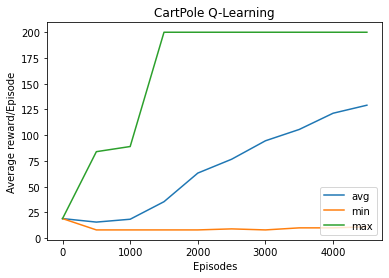

In [29]:
#Hyperparamters
EPISODES = 5000       #Number of episodes: applied for training the reinforcement learning model
DISCOUNT = 0.95       #Discount factor: used to measure how far ahead in time the algorithm must look,
                      #   i.e., if factor=0 none of the future rewards are considered in Q-learning; 
                      #   if factor=1 future rewards are given a high weight
EPISODE_DISPLAY = 500 #Episode Display: defines the number of episodes necessary to run before 
                      #   rendering the episode, i.e., episodes 0,500,1000,1500, .. are rendered. 
                      #   Positive to visually verify learning evolution of RL model
LEARNING_RATE = 0.25  #Learning rate: set between [0,1], applied to facilitate the Q-value update 
                      #   at a desired rate, i.e., if rate=0 then Q-values are never updated and nothing 
                      #   is learnt; if rate=1 then nothing is added to the current Q-value
EPSILON = 0.25        #Exploration constant: used to give the bot an element of exploration, 
                      #   i.e., if epsilon=0 then the algorithm only considers actions corresponding 
                      #   to the highest Q-value; if epsilon=1 then the algorithm only selects 
                      #   random action values

#Environment creation
env = gym.make("CartPole-v0")
env.reset()
#Environment values: continuous min and max values for each observation
#[Horizontal position, Horizontal velocity, Angle of Pole, Angular velocity]
print('Env. Observation Space - High:', env.observation_space.high)    
print('Env. Observation Space - Low:', env.observation_space.low)
print('Env. Actions Space:', env.action_space.n) #number of possible actions: 0-left, 1-Right

ep_rewards_table = train_cart_pole_qlearning(env, EPISODES, DISCOUNT, EPISODE_DISPLAY, LEARNING_RATE, EPSILON)

#Plot Model evolution performance
plot_RL_learning(ep_rewards_table, 'CartPole Q-Learning')    